In [1]:
import sys
import numpy as np
import math
import ceo
import matplotlib.pyplot as plt
import IPython
%matplotlib inline

In [2]:
# Telescope parameters
D = 26.
nPx = 469
radial_order = 4
gmt = ceo.GMT_MX(D,nPx,M1_radial_order=radial_order,M2_radial_order=radial_order)

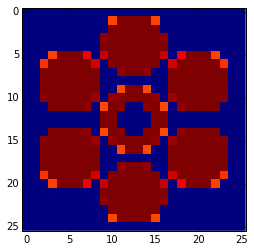

In [3]:
# on-axis WFS parameters
nLenslet = 26  # number of sub-apertures across the pupil
n = 18         # number of pixels per subaperture
detectorRes = 2*n*nLenslet/2
BINNING = 2

# Initialize on-axis GS and WFS
ongs = ceo.Source("R",zenith=0.,azimuth=0., rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
wfs = ceo.ShackHartmann(nLenslet, n, D/nLenslet,N_PX_IMAGE=2*n,BIN_IMAGE=BINNING,N_GS=1)

# Calibrate WFS slope null vector
ongs.reset()
gmt.reset()   # Telescope perfectly phased
gmt.propagate(ongs)
wfs.calibrate(ongs,0.8)
plt.imshow(wfs.flux.host(shape=(nLenslet,nLenslet)),interpolation='none')

In [4]:
print wfs.frame.shape
print "pupil sampling:      %d pixel"%nPx
print "Pixel size: %.3farcsec"%(wfs.pixel_scale_arcsec)
sh_fov = wfs.pixel_scale_arcsec*wfs.N_PX_IMAGE/BINNING
print "Field of view: %.3farcsec"%(sh_fov)

(468, 468)
pupil sampling:      469 pixel
Pixel size: 0.132arcsec
Field of view: 2.376arcsec


(1, 219961, 1)


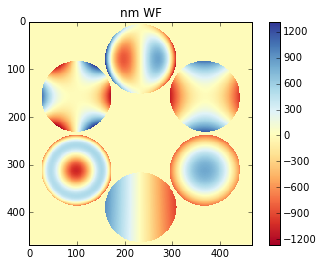

In [5]:
#Get residual WF solely due to telescope aberrations when perfectly aligned
ongs.reset()
gmt.reset()
gmt.propagate(ongs)
Wref = np.rollaxis( ongs.wavefront.phase.host(units='nm', shape=(1,ongs.N_SRC,ongs.n*ongs.m)),1,3)

#Put some Zernike modes on M1 segments and get the WF
zmode = np.array((2,4,6,8,10,11))
zstroke = 250e-9 #m rms SURF
ongs.reset()
gmt.reset()
for ii in range(zmode.size):
    gmt.M1.zernike.a[ii,zmode[ii]-1] = zstroke
    gmt.M1.zernike.update()
gmt.propagate(ongs)
W = np.rollaxis( ongs.wavefront.phase.host(units='nm', shape=(1,ongs.N_SRC,ongs.n*ongs.m)),1,3)
print W.shape

plt.imshow(ongs.phase.host(units='nm'),interpolation='None',cmap='RdYlBu')
plt.colorbar()
plt.title("nm WF")

In [6]:
## Initialize the projection of segment phasemaps onto Zernikes
Zobj = ceo.ZernikeS(radial_order)
P = np.rollaxis( np.array( ongs.rays.piston_mask ),0,3)

# Find center coordinates (in pixels) of each segment mask
u = np.arange(ongs.n)
v = np.arange(ongs.m)
x,y = np.meshgrid(u,v)
x = x.reshape(1,-1,1)
y = y.reshape(1,-1,1)
xc = np.sum(x*P,axis=1)/P.sum(axis=1)
yc = np.sum(y*P,axis=1)/P.sum(axis=1)

# Preliminary estimation of radius (in pixels) of each segment mask (assuming that there is no central obscuration)
Rs = np.sqrt(P.sum(axis=1)/np.pi)

# Polar coordinates
rho   = np.hypot(   x - xc[:,np.newaxis,:], y - yc[:,np.newaxis,:])   #temporal rho vector
theta = np.arctan2( y - yc[:,np.newaxis,:], x - xc[:,np.newaxis,:]) * P

#Estimate central obscuration area of each segment mask
ObsArea = np.sum(rho < 0.9*Rs[:,np.newaxis,:] * ~P.astype('bool'), axis=1)

#Improve estimation of radius of each segment mask
Rs = np.sqrt( (P.sum(axis=1)+ObsArea) / np.pi)

#Normalize rho vector (unitary radius)
rho = rho*P / Rs[:,np.newaxis,:] #final rho vector

#caca = rho[3,:,:].reshape(ongs.n,ongs.m)
#plt.imshow(caca)
#plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2ac11a5a5e60>

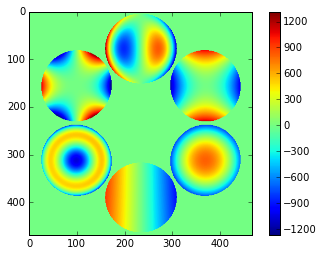

In [17]:
#Project a segment at a time:
segId = 1
alphaId = 0 #direction in the FoV (in case N_SRC > 0)

cutheta = ceo.cuDoubleArray(host_data=theta[segId-1,:,alphaId].reshape(ongs.m,ongs.n))
curho   = ceo.cuDoubleArray(host_data=  rho[segId-1,:,alphaId].reshape(ongs.m,ongs.n))
#myphase = ((W-Wref)[:,:,alphaId]*P[segId-1,:,alphaId]).reshape(ongs.n,ongs.m)  #just the WF over one segment
myphase = (W-Wref)[:,:,alphaId].reshape(ongs.n,ongs.m)
cuW = ceo.cuFloatArray(host_data=myphase)

plt.imshow(cuW.host())
plt.colorbar()

Zobj.projection(cuW, curho, cutheta) 
print Zobj.a

In [ ]:
Zobj.reset()
print Zobj.a
Zobj.a[0,0] = 0
ZS = Zobj.surface(curho,cutheta)
plt.imshow(ZS.host())
plt.colorbar()